In [ ]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lars
import plotly.express as px
import datetime as dt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from statsmodels.tsa.ar_model import AutoReg

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#data = pd.read_csv('drive/MyDrive/TechPet/Project 1/data_cleaned.csv')
data = pd.read_csv('drive/MyDrive/Tech Pet/Data/data_cleaned.csv')
data_1 = data[['Date', 'Water']]

In [ ]:
data_1['Date'] = pd.to_datetime(data_1['Date'])

In [ ]:
# resample dataframe monthly
data_resampled = (data_1.set_index('Date')).resample('M', convention = 'end').mean().bfill(axis = 0)

# create Gas series
water_data = pd.DataFrame(data_resampled['Water'], index = data_resampled.index)

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

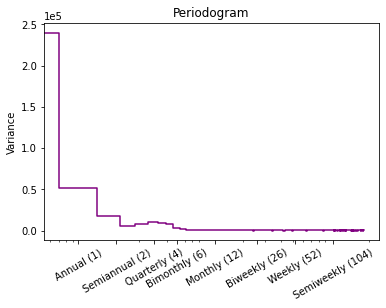

In [ ]:
plot_periodogram(water_data.Water)

In [ ]:
fourier = CalendarFourier(freq = "M", order = 6)

dp = DeterministicProcess(
    index = water_data.index,
    drop = True,
    seasonal = True,
    additional_terms = [fourier] 
)

water_data_1 = dp.in_sample()

In [ ]:
water_data_1['Water'] = water_data['Water']

In [ ]:
def lag_features(data, column, no):
    for i in range(no):
        data['Lag' + str(i + 1)] = data[column].shift(i + 1)
    return data

In [ ]:
water_data_1 = lag_features(water_data_1, 'Water', 42)

In [ ]:
water_data_1.head()

,"s(1,12)","s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)",...,Lag33,Lag34,Lag35,Lag36,Lag37,Lag38,Lag39,Lag40,Lag41,Lag42
Date,,,,,,,,,,,,,,,,,,,,,
1978-07-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-08-31,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-09-30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-10-31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-11-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
water_data_2 = water_data_1.dropna()

In [ ]:
y = water_data_2['Water']
X = water_data_2.drop('Water', axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (379, 55)
y_train shape: (379,)
X_test shape: (95, 55)
y_test shape: (95,)


In [ ]:
linear_model = LinearRegression()

In [ ]:
linear_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
linear_model.score(X_train, y_train)

0.960713958019584

In [ ]:
linear_model.score(X_test, y_test)

0.9500142637297516

In [ ]:
test_pred = linear_model.predict(X_test)
error = mean_absolute_error(y_test, test_pred)

In [ ]:
print(error)

103.20379515367406


### XGB Model

In [ ]:
data_1 = water_data_1.copy()

In [ ]:
data_1.head(2)

,"s(1,12)","s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)",...,Lag33,Lag34,Lag35,Lag36,Lag37,Lag38,Lag39,Lag40,Lag41,Lag42
Date,,,,,,,,,,,,,,,,,,,,,
1978-07-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-08-31,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
y = data_1['Water']
X = data_1.drop('Water', axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (412, 55)
y_train shape: (412,)
X_test shape: (104, 55)
y_test shape: (104,)


In [ ]:
xgb_model = XGBRegressor()

In [ ]:
xgb_model.fit(X_train, y_train)

[04:22:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
xgb_model.score(X_train, y_train)

0.9979190355068761

In [ ]:
xgb_model.score(X_test, y_test)

0.91438891111761

In [ ]:
test_pred = xgb_model.predict(X_test)
error = mean_absolute_error(y_test, test_pred)